In [1]:
import pickle
import os
import sys

dir2 = os.path.abspath("")
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir("../..")

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import shap
from sklearn.metrics import ndcg_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from sklearn.metrics import r2_score
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns


libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS: 
/home/user/conda/envs/recsys/lib/python3.9/site-packages/numba/core/config.py:154: RuntimeWarning: environ NUMBA_NUM_THREADS defined but failed to parse ''
  warnings.warn("environ %s defined but failed to parse '%s'" %

libgomp: Invalid value for environment variable OMP_NUM_THREADS
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import optuna

In [4]:
SAMPLE_RATE = 0.4
RANDOM_SEED = 1
EARLY_STOPPING_ROUND = 100

In [5]:
X = pd.read_csv(os.path.join("notebooks", "feature_importance", "data.csv"), index_col=False)

In [6]:
X = X[X.columns.difference(['FracInteractionsVal', 'FracInteractionsTest',
       'FracPassiveUsersVal', 'FracPassiveUsersTest', 'FracPassiveItemsVal',
       'FracPassiveItemsTest',])]

In [7]:
# Split by dataset_name to ensure entire groups are in train or test, not split between them
train_datasets, test_datasets = train_test_split(X['Dataset'].unique(), test_size=0.1, random_state=142)

train_df = X[X['Dataset'].isin(train_datasets)]
test_df = X[X['Dataset'].isin(test_datasets)]

In [8]:
# Split into training and testing sets
# Split by dataset_name to ensure entire groups are in train or test, not split between them
train_datasets, test_datasets = train_test_split(X['Dataset'].unique(), test_size=0.05, random_state=4124)

train_df = X[X['Dataset'].isin(train_datasets)]
test_df = X[X['Dataset'].isin(test_datasets)]

In [9]:
X_train = train_df[train_df.columns.difference(['Dataset', 'Method',])].astype(float)
X_train['Method'] = train_df['Method']
y_train = X_train.pop('Value')

X_test = test_df[test_df.columns.difference(['Dataset', 'Method',])].astype(float)
X_test['Method'] = test_df['Method']
y_test = X_test.pop('Value')

In [16]:
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001)
    param['depth'] = trial.suggest_int('depth', 9, 15)
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['grow_policy'] = 'Depthwise'
    param['iterations'] = 10000
    param['use_best_model'] = True
    param['eval_metric'] = 'RMSE'
    param['od_type'] = 'iter'
    param['od_wait'] = 20
    param['random_state'] = RANDOM_SEED
    param['logging_level'] = 'Silent'
    
    regressor = CatBoostRegressor(cat_features=['Method'], **param)

    regressor.fit(X_train.copy(), y_train.copy(),
                  eval_set=[(X_test.copy(), y_test.copy())],
                  early_stopping_rounds=EARLY_STOPPING_ROUND)
    loss = mean_squared_error(y_test, regressor.predict(X_test.copy()))
    return loss

In [17]:
study = optuna.create_study(study_name=f'catboost-seed{RANDOM_SEED}')
study.optimize(objective, n_trials=100, n_jobs=-1, timeout=24000)

[I 2023-10-10 10:17:41,233] A new study created in memory with name: catboost-seed1
suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
[I 2023-10-10 10:17:47,167] Trial 16 finished with value: 0.0007879346824465445 and parameters: {'learning_rate': 0.02, 'depth': 9, 'l2_leaf_reg': 5.0, 'min_child_samples': 32}. Best is trial 16 with value: 0.0007879346824465445.
suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. Se

In [32]:
study.best_params

{'learning_rate': 0.02,
 'depth': 10,
 'l2_leaf_reg': 5.0,
 'min_child_samples': 16}

In [33]:
X_train_full = X[X.columns.difference(['Value','Dataset', 'Method',])].astype(float)
X_train_full['Method'] = X['Method']
y_train_full = X['Value']

In [34]:
regressor = CatBoostRegressor(cat_features=['Method'], **study.best_params)

regressor.fit(X_train_full, y_train_full,
                early_stopping_rounds=EARLY_STOPPING_ROUND)

# Predict
y_pred = regressor.predict(X_train_full)

0:	learn: 0.0569657	total: 3.29ms	remaining: 3.29s
1:	learn: 0.0565303	total: 6.35ms	remaining: 3.17s
2:	learn: 0.0560900	total: 8.36ms	remaining: 2.78s
3:	learn: 0.0557296	total: 10.1ms	remaining: 2.52s
4:	learn: 0.0553059	total: 12.7ms	remaining: 2.52s
5:	learn: 0.0549089	total: 14.6ms	remaining: 2.41s
6:	learn: 0.0545584	total: 17.1ms	remaining: 2.42s
7:	learn: 0.0541541	total: 19.3ms	remaining: 2.4s
8:	learn: 0.0538357	total: 19.9ms	remaining: 2.19s
9:	learn: 0.0535431	total: 20.3ms	remaining: 2.01s
10:	learn: 0.0531980	total: 22.2ms	remaining: 1.99s
11:	learn: 0.0528607	total: 23.7ms	remaining: 1.95s
12:	learn: 0.0524713	total: 25.8ms	remaining: 1.96s
13:	learn: 0.0521282	total: 27.2ms	remaining: 1.92s
14:	learn: 0.0518377	total: 29.3ms	remaining: 1.92s
15:	learn: 0.0515504	total: 31.5ms	remaining: 1.94s
16:	learn: 0.0512432	total: 33.4ms	remaining: 1.93s
17:	learn: 0.0509866	total: 35.2ms	remaining: 1.92s
18:	learn: 0.0506258	total: 36.6ms	remaining: 1.89s
19:	learn: 0.0503485	to

In [36]:
# Calculate the R2 score
r2 = r2_score(y_train_full, y_pred)

print("R-squared (R2) Score:", r2)

R-squared (R2) Score: 0.726744162344907


In [39]:
explainer = shap.TreeExplainer(regressor)
shap_values = explainer(X_train_full, y_train_full)

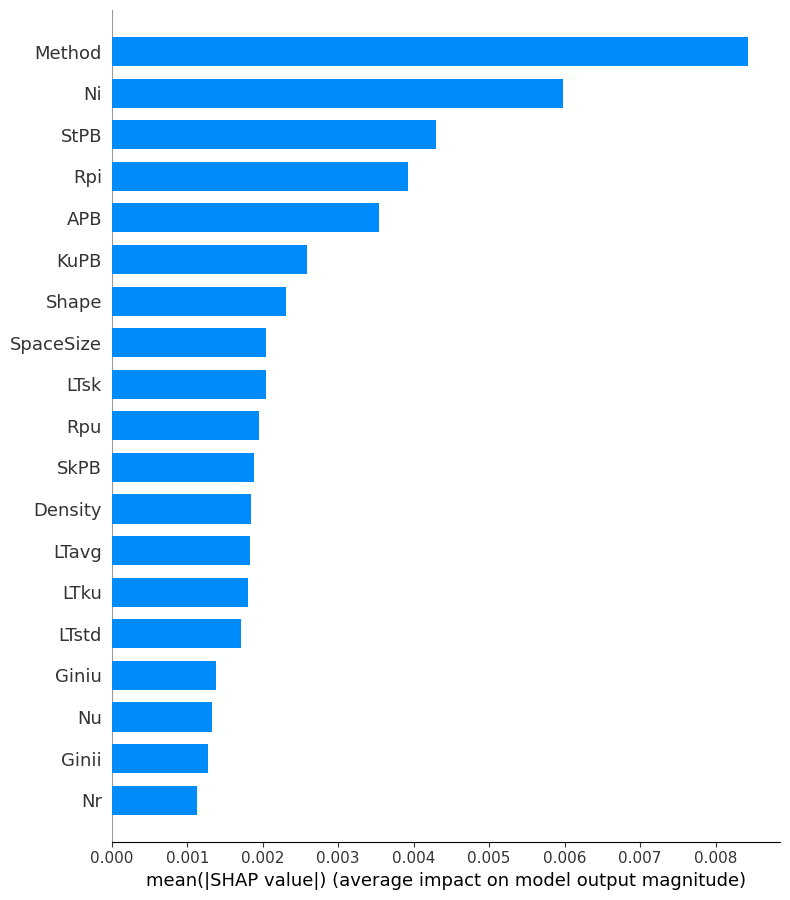

In [40]:
shap.summary_plot(shap_values, X_train_full, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


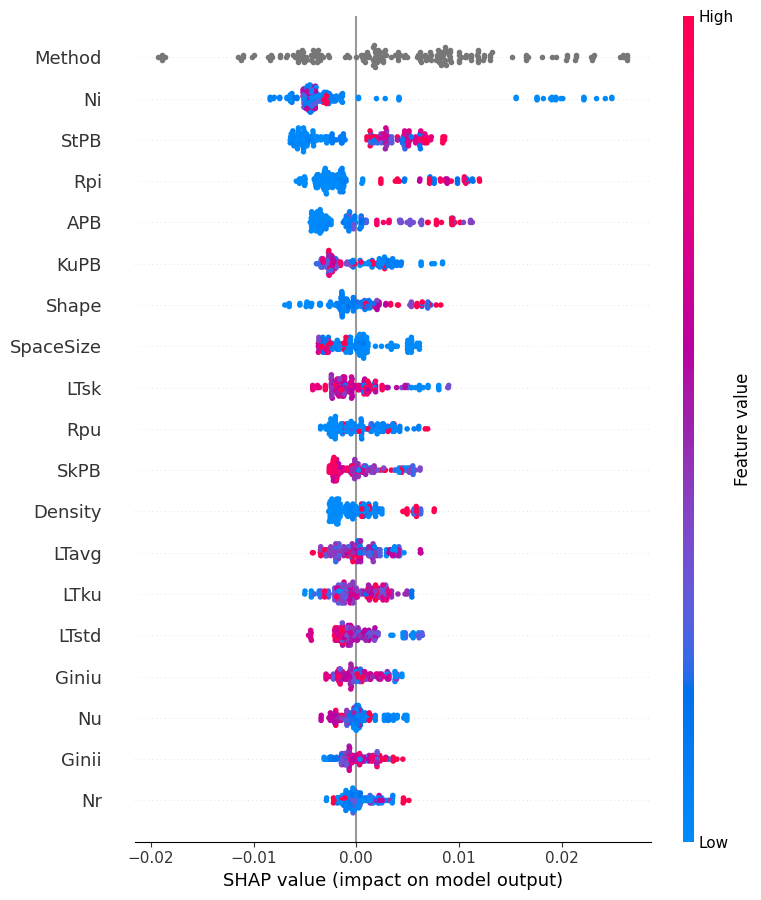

In [41]:
shap.summary_plot(shap_values, X_train_full)